In [1]:
import sympy as sp

def sym_basis_k_symbolic(k, d=3):
    basis = []
    
    # Factorials and sqrt become symbolic
    factorial = sp.factorial
    sqrt = sp.sqrt
    
    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts
            
            norm = sqrt(factorial(a) * factorial(b) * factorial(c) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return
        
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# Test
for vec, norm in sym_basis_k_symbolic(4):
    print(vec, norm)


(4, 0, 0) 1
(3, 1, 0) 1/2
(3, 0, 1) 1/2
(2, 2, 0) sqrt(6)/6
(2, 1, 1) sqrt(3)/6
(2, 0, 2) sqrt(6)/6
(1, 3, 0) 1/2
(1, 2, 1) sqrt(3)/6
(1, 1, 2) sqrt(3)/6
(1, 0, 3) 1/2
(0, 4, 0) 1
(0, 3, 1) 1/2
(0, 2, 2) sqrt(6)/6
(0, 1, 3) 1/2
(0, 0, 4) 1


Let $d=3$ and consider a matrix $M \in \mathbb{R}^{3 \times 3}$.  
Let $\alpha = (\alpha_0, \alpha_1, \alpha_2)$ and $\beta = (\beta_0, \beta_1, \beta_2)$ be multi-indices corresponding to basis vectors in $\mathrm{Sym}^k(\mathbb{R}^3)$.

We want the matrix element of the symmetric projection:

$$
\pi(M^{\otimes k})_{\alpha,\beta} = \sum_{T \in \mathcal{T}(\alpha,\beta)} 
\frac{k!}{\prod_{i,j} T_{ij}!} \prod_{i,j} M_{ij}^{T_{ij}}
$$

where $\mathcal{T}(\alpha,\beta)$ is the set of $3 \times 3$ matrices $T = (T_{ij})$ with row sums $\alpha$ and column sums $\beta$:

$$
\sum_{j=0}^2 T_{ij} = \alpha_i, \quad \sum_{i=0}^2 T_{ij} = \beta_j.
$$

---

*Recursive computation*

Define a recursive function to sum over all valid splits of $\alpha$ into contributions to $\beta$:

1. Start at row $u=0$ with remaining column sums $\beta^{(0)} = \beta$.  
2. Generate all partitions of $\alpha_0$ into three non-negative integers $(T_{0,0}, T_{0,1}, T_{0,2})$.  
3. For each valid split satisfying $T_{0,j} \le \beta^{(0)}_j$, update remaining column sums:

$$
\beta^{(1)}_j = \beta^{(0)}_j - T_{0,j}, \quad j=0,1,2
$$

4. Recurse to row $u=1$ with sum $\alpha_1$ and remaining column sums $\beta^{(1)}$.  
5. Continue to row $u=2$ with $\alpha_2$ and $\beta^{(2)}$.  
6. If all remaining column sums are zero at the last row, the split $T$ is valid.  
7. Contribution of $T$ to the sum:

$$
\text{term}(T) = \frac{k!}{\prod_{i,j} T_{ij}!} \prod_{i,j} M_{ij}^{T_{ij}}.
$$

---

*Recursive formula*

Let $f(\alpha, \beta, u)$ denote the recursive sum at row $u$:

$$
f(\alpha, \beta, u) =
\sum_{\substack{(T_{u,0},T_{u,1},T_{u,2}) \\ \sum_j T_{u,j} = \alpha_u \\ T_{u,j} \le \beta_j}}
\left[ \frac{\alpha_u!}{\prod_{j=0}^2 T_{u,j}!} 
\prod_{j=0}^2 M_{u,j}^{T_{u,j}} \cdot f(\alpha, \beta - T_{u,\cdot}, u+1) \right]
$$

with base case:

$$
f(\alpha, \beta, u=3) = 
\begin{cases}
1 & \text{if } \beta = (0,0,0),\\
0 & \text{otherwise}.
\end{cases}
$$

Finally, multiply by the basis norm factors to get the corresponding entry of the projected symmetric tensor:

$$
\pi(M^{\otimes k})_{\alpha,\beta} = \text{norm}_\alpha \cdot \text{norm}_\beta \cdot f(\alpha, \beta, 0)
$$


In [18]:
import sympy as sp
from functools import lru_cache

def pi_symmetric_multinomial_opt(M, basis, numeric=False):
    """
    Compute the symmetric multinomial projection of M on the given basis.

    Args:
        M (sp.Matrix): d x d symbolic matrix.
        basis (list): List of (vector, norm) tuples from sym_basis_k_symbolic.
        numeric (bool): If True, evaluates numerically to speed up large k.

    Returns:
        sp.Matrix: Projected matrix.
    """
    d = M.rows
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Maximum degree k (all basis vectors have same degree)
    max_k = sum(basis[0][0])
    factorials = [factorial(i) for i in range(max_k + 1)]

    # Precompute powers of M
    powers = {}
    for u in range(d):
        for v in range(d):
            powers[(u, v)] = [1]  # M[u,v]^0
            val = 1
            for t in range(1, max_k + 1):
                val *= M[u, v]
                powers[(u, v)].append(val)

    # Function to enumerate contingency matrices
    def enum_contingency(rows, cols):
        @lru_cache(maxsize=None)
        def _recurse(row_idx, cols_remaining):
            cols_remaining = list(cols_remaining)
            if row_idx == len(rows):
                if all(c == 0 for c in cols_remaining):
                    return [()]
                return []
            results = []
            target = rows[row_idx]

            def compose(pos, left, current):
                if pos == len(cols_remaining) - 1:
                    val = left
                    if val <= cols_remaining[pos]:
                        yield tuple(current + [val])
                    return
                maxv = min(left, cols_remaining[pos])
                for v in range(maxv, -1, -1):
                    yield from compose(pos + 1, left - v, current + [v])

            for row_choice in compose(0, target, []):
                new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(len(cols_remaining)))
                for tail in _recurse(row_idx + 1, new_cols):
                    results.append(tuple(row_choice) + tail)
            return results

        return _recurse(0, tuple(cols))

    # Compute projection matrix
    for i_idx, (vec_i, norm_i) in enumerate(basis):
        for j_idx, (vec_j, norm_j) in enumerate(basis):
            val = 0
            for mat_flat in enum_contingency(tuple(vec_i), tuple(vec_j)):
                term = 1
                denom = 1
                for u in range(d):
                    for v in range(d):
                        t = mat_flat[u * d + v]
                        if t:
                            term *= powers[(u, v)][t]
                            denom *= factorials[t]
                val += factorials[max_k] / denom * term
            piM[i_idx, j_idx] = norm_i * norm_j * val
            if numeric:
                piM[i_idx, j_idx] = sp.N(piM[i_idx, j_idx])

    return piM


In [19]:
# --- Test ---
d = 3
k_val = 10
M = sp.Matrix([[sp.symbols(f'M{i}{j}') for j in range(1, d + 1)] for i in range(1, d + 1)])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_multinomial_opt(M, basis)
#display(piM)

In [20]:
import sympy as sp
import random

# assume these functions are already defined from previous code:
# - sym_basis_k_symbolic
# - pi_symmetric_multinomial

def random_int_matrix(d, lo=-3, hi=3):
    """Generate a random integer dxd SymPy matrix."""
    return sp.Matrix([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)])


def test_representation_property(d=3, k_val=4, trials=3):
    print(f"Testing π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    # fixed basis for this k and d
    basis = sym_basis_k_symbolic(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random integer matrices A, B
        A = random_int_matrix(d)
        B = random_int_matrix(d)
        AB = A * B

        print("A =", A)
        print("B =", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial_opt(A, basis)
        piB = pi_symmetric_multinomial_opt(B, basis)
        piAB = pi_symmetric_multinomial_opt(AB, basis)

        # Compare
        diff = sp.simplify(piAB - (piA * piB))

        if diff == sp.zeros(*diff.shape):
            print("✅ PASS:  pi(AB) == pi(A)*pi(B)")
        else:
            print("❌ FAIL!")
            print("Difference:")
            display(diff)
            return False  # early stop

    print("\nAll tests passed ✅")
    return True


# Run the property test
if __name__ == "__main__":
    random.seed(0)
    test_representation_property(d=3, k_val=10, trials=3)

Testing π(AB) = π(A) π(B) for S^10(ℂ^3) ...

--- Trial 1 ---
A = Matrix([[3, 0, 3], [0, -3, -1], [1, 0, 0]])
B = Matrix([[3, 3, -1], [0, -1, 1], [-2, 1, -2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 2 ---
A = Matrix([[-1, -2, 3], [-3, 1, 3], [-1, 1, 2]])
B = Matrix([[3, 1, -2], [-1, -3, 2], [-3, 3, 2]])


KeyboardInterrupt: 

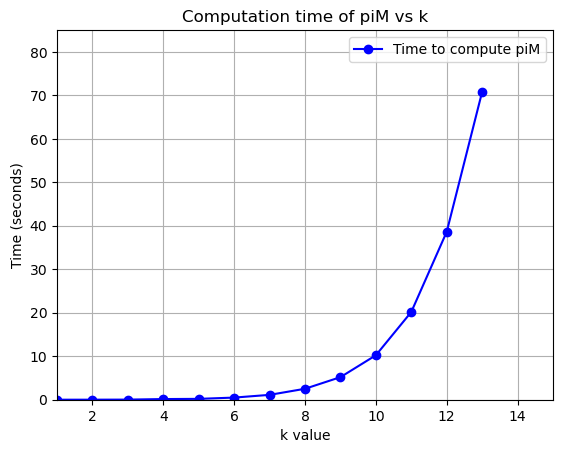

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Assume sym_basis_k_symbolic and pi_symmetric_multinomial are already defined
d = 3
M = sp.Matrix([[sp.symbols(f'M{i}{j}') for j in range(1, d + 1)] for i in range(1, d + 1)])

k_values = list(range(1, 16))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()

    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_multinomial_opt(M, basis)

    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 15)
    plt.ylim(0, max(times)*1.2)
    plt.show()

In [ ]:
import sympy as sp
from math import factorial
from itertools import product

def partitions(s, k):
    if k == 1:
        yield (s,)
    else:
        for i in range(s + 1):
            for tail in partitions(s - i, k - 1):
                yield (i,) + tail

def multinomial_recursive(alpha_rows, beta_col, M_list, factorials, u=0):
    d = len(beta_col)
    if u == d:
        return 1 if all(b == 0 for b in beta_col) else 0

    total = 0
    row_sum = alpha_rows[u]
    for split in partitions(row_sum, d):
        if all(split[v] <= beta_col[v] for v in range(d)):
            new_beta = [beta_col[v] - split[v] for v in range(d)]
            row_factor = factorials[row_sum]
            for t in split:
                row_factor //= factorials[t]
            row_term = 1
            for v in range(d):
                if split[v]:
                    row_term *= M_list[u][v]**split[v]
            total += row_factor * row_term * multinomial_recursive(alpha_rows, new_beta, M_list, factorials, u + 1)
    return total

def pi_symmetric_multinomial_fast(M, basis, numeric=False):
    d = M.rows
    n = len(basis)
    piM = sp.zeros(n, n)
    M_list = [[M[u, v] for v in range(d)] for u in range(d)]
    factorials = [factorial(i) for i in range(sum(basis[0][0]) + 1)]

    for i_idx, (alpha, norm_i) in enumerate(basis):
        for j_idx, (beta, norm_j) in enumerate(basis):
            val = multinomial_recursive(alpha, list(beta), M_list, factorials)
            k = sum(alpha)
            val *= factorials[k]
            piM[i_idx, j_idx] = norm_i * norm_j * val
            if numeric:
                piM[i_idx, j_idx] = sp.N(piM[i_idx, j_idx])
    return piM

# Symmetric basis function
def sym_basis_k_symbolic(k, d=3):
    basis = []
    factorial_sym = sp.factorial
    sqrt = sp.sqrt
    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            norm = sqrt(sp.prod([factorial_sym(p) for p in parts]) / factorial_sym(k))
            basis.append((tuple(parts), norm))
            return
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])
    generate(k, [])
    return basis


In [ ]:
%load_ext line_profiler

d = 3
k_val = 10
U = sp.Matrix(sp.symbols('u11 u12 u13 u21 u22 u23 u31 u32 u33')).reshape(d, d)
basis = sym_basis_k_symbolic(k_val, d)

# Now profile the function
%lprun -f pi_symmetric_multinomial_fast pi_symmetric_multinomial_fast(U, basis)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-07 s

Total time: 32.0338 s
File: C:\Users\martin\AppData\Local\Temp\ipykernel_10276\1903341637.py
Function: pi_symmetric_multinomial_fast at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def pi_symmetric_multinomial_fast(M, basis, numeric=False):
    34         1         11.0     11.0      0.0      d = M.rows
    35         1          8.0      8.0      0.0      n = len(basis)
    36         1        343.0    343.0      0.0      piM = sp.zeros(n, n)
    37         1        438.0    438.0      0.0      M_list = [[M[u, v] for v in range(d)] for u in range(d)]
    38         1         26.0     26.0      0.0      factorials = [factorial(i) for i in range(sum(basis[0][0]) + 1)]
    39                                           
    40        67        514.0      7.7      0.0      for i_idx, (alpha, norm_i) in enumerate(basis):
    41      4422      37158.0      8.4      0.0          for j_idx, (beta, no

In [ ]:
from sympy import Matrix
# Example: small test matrix and basis
d = 3
k_val = 3
U = Matrix([[sp.symbols(f'u{i}{j}') for j in range(1,d+1)] for i in range(1,d+1)])
basis = sym_basis_k_symbolic(k_val, d)

# Profile the function
%lprun -f pi_symmetric_multinomial_fast pi_symmetric_multinomial_fast(U, basis)


NameError: name 'b' is not defined

In [ ]:
import cProfile
import pstats
import sympy as sp
from math import factorial
from itertools import product


# Example setup
d = 3
k_val = 10  # keep small for profiling
U = sp.Matrix([[sp.symbols(f'u{i}{j}') for j in range(1, d+1)] for i in range(1, d+1)])
basis = sym_basis_k_symbolic(k_val, d)

# Wrap the function call in another function for cProfile
def run_projection():
    piM = pi_symmetric_multinomial_fast(U, basis, numeric=False)
    return piM

# Profile the function
profiler = cProfile.Profile()
profiler.enable()
piM_result = run_projection()
profiler.disable()

# Print stats sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats(30)  # top 30 slowest functions

# Optional: sort by total time instead
# stats.sort_stats('tottime').print_stats(30)


         151471374 function calls (140522193 primitive calls) in 43.652 seconds

   Ordered by: cumulative time
   List reduced from 281 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   43.652   21.826 c:\Users\martin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        7    0.000    0.000   34.022    4.860 c:\Users\martin\anaconda3\Lib\asyncio\base_events.py:1962(_run_once)
        7    0.000    0.000   34.022    4.860 c:\Users\martin\anaconda3\Lib\selectors.py:310(select)
        7    0.492    0.070   34.021    4.860 c:\Users\martin\anaconda3\Lib\selectors.py:304(_select)
533819/533799    0.416    0.000   33.052    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\decorators.py:224(_func)
533819/533799    0.280    0.000   31.655    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\decorators.py:99(binary_op_wrapper)
2344174/844470    1.225    0.000 

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# --- Test ---
d = 3
k_val = 10
M = sp.Matrix([[sp.symbols(f'M{i}{j}') for j in range(1, d + 1)] for i in range(1, d + 1)])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_multinomial_fast(M, basis)
#display(piM)

In [ ]:
import sympy as sp
import random

# assume these functions are already defined from previous code:
# - sym_basis_k_symbolic
# - pi_symmetric_multinomial

def random_int_matrix(d, lo=-3, hi=3):
    """Generate a random integer dxd SymPy matrix."""
    return sp.Matrix([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)])


def test_representation_property(d=3, k_val=4, trials=3):
    print(f"Testing π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    # fixed basis for this k and d
    basis = sym_basis_k_symbolic(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random integer matrices A, B
        A = random_int_matrix(d)
        B = random_int_matrix(d)
        AB = A * B

        print("A =", A)
        print("B =", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial_fast(A, basis)
        piB = pi_symmetric_multinomial_fast(B, basis)
        piAB = pi_symmetric_multinomial_fast(AB, basis)

        # Compare
        diff = sp.simplify(piAB - (piA * piB))

        if diff == sp.zeros(*diff.shape):
            print("✅ PASS:  pi(AB) == pi(A)*pi(B)")
        else:
            print("❌ FAIL!")
            print("Difference:")
            display(diff)
            return False  # early stop

    print("\nAll tests passed ✅")
    return True


# Run the property test
if __name__ == "__main__":
    random.seed(0)
    test_representation_property(d=3, k_val=10, trials=3)

Testing π(AB) = π(A) π(B) for S^10(ℂ^3) ...

--- Trial 1 ---
A = Matrix([[3, 0, 3], [0, -3, -1], [1, 0, 0]])
B = Matrix([[3, 3, -1], [0, -1, 1], [-2, 1, -2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 2 ---
A = Matrix([[-1, -2, 3], [-3, 1, 3], [-1, 1, 2]])
B = Matrix([[3, 1, -2], [-1, -3, 2], [-3, 3, 2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 3 ---
A = Matrix([[-1, 0, 1], [-3, -1, 0], [-1, 1, 2]])
B = Matrix([[-2, 1, 0], [0, 3, 1], [-1, -3, 3]])
✅ PASS:  pi(AB) == pi(A)*pi(B)

All tests passed ✅
